<IPython.core.display.Javascript object>


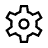


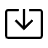


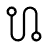


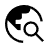


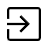


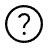


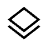


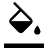


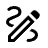


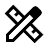


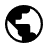

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [4]:
from ipyleaflet import Map, Marker, Polyline, WidgetControl, CircleMarker, Popup, LayerGroup, DivIcon, Rectangle, DrawControl, basemaps
from ipywidgets import Button, FileUpload
import ipywidgets as widgets
from IPython.display import display, HTML, Javascript
from pathlib import Path
import base64
from geographiclib.geodesic import Geodesic
import os
import numpy as np
import zipfile
import io
from scipy.interpolate import make_interp_spline


custom_css = """
<style>
    .widget-dropdown > select:hover, .widget-dropdown > select:focus {
        background-color: #10a393;  /* or any color of your choice */
    }
</style>
"""

css_line_spacing = """
<style>
    .jupyter-widgets .widget-label, 
    .jupyter-widgets .widget-readout,
    .jupyter-widgets .widget-html-content {
        line-height: 1.3;   /* Adjust this value as per your preference. Default is typically 1.5. */
        font-size: 1em;
    }
</style>
"""
display(HTML(css_line_spacing))

# CSS styles for button appearance
css_button_styles = """
<style>
    .custom-button {
        background-color: #1f4b61 !important;
        color: white !important;
        font-weight: bold !important;
        font-size: 1em;
        font-family: Segoe UI;
    }
    
    .custom-button:hover {
        background-color: #10a393 !important;
        color: white !important;
        font-size: 1em;
    }
    
    .custom-button:active {
        background-color: #10a393 !important;
        color: white !important;
        font-size: 1em;
    }
</style>
"""
display(HTML(css_button_styles))

def load_logo(logo_path):
    with open(logo_path, "rb") as f:
        image = f.read()
    return widgets.Image(value=image, format='png', layout=widgets.Layout(width='23%'))

logo_path = "./LOGO.png"
logo_widget = load_logo(logo_path)
logo_widget.layout.width = '80%'
logo_widget.layout.margin = '0 auto 30px auto'
logo_widget.layout.display = 'block'

last_button_id = None
draw_control = None

# Add the global variable here
hub_creation_mode = False
point_creation_mode = False  # Add this line
line_creation_mode = False
selected_points = []
all_points = []
line_coordinates = []
# Create lists to keep track of hubs, points, and lines
hubs = []
points = []
lines = []


# Define the draw control and its configurations
draw_control = DrawControl(
    marker={'shapeOptions': {'color': '#1f4b61'}},
    polyline={'shapeOptions': {'color': '#1f4b61'}},
    polygon={'shapeOptions': {'color': '#1f4b61'}},
    rectangle={'shapeOptions': {'color': '#1f4b61'}},
    circlemarker={},
    edit=True,
    remove=True
)

def measure_drawn_shape(shape, map_units):
    if isinstance(shape, dict) and 'type' in shape:
        coordinates = shape['coordinates']
        if shape['type'] == "LineString":  # Measure distance
            distance = 0
            for i in range(len(coordinates) - 1):
                distance += Geodesic.WGS84.Inverse(coordinates[i][1], coordinates[i][0], coordinates[i+1][1], coordinates[i+1][0])["s12"]
            distance /= 1000  # Convert to km
            return f"Distance: {distance:.2f} km"
        elif shape['type'] == "Polygon":  # Measure area
            area = Geodesic.WGS84.Area(coordinates[0])["s12"]
            area /= (1000 * 1000)  # Convert to square km
            return f"Area: {abs(area):.2f} sq.km"
    return ""


# MAP SETTINGS

map_units_dropdown = widgets.Dropdown(
    options=['meters', 'kilometers'],
    value='meters',
    description='Map units:'
)

def on_map_unit_change(change):
    # You can set any logic needed to adjust the map units here
    print(f"Map unit changed to {change['new']}")

map_units_dropdown.observe(on_map_unit_change, names='value')

basemap_choices = {
    'OpenStreetMap Mapnik': basemaps.OpenStreetMap.Mapnik,
    'ESRI Satellite': basemaps.Esri.WorldImagery,
    'Simple Gray': basemaps.CartoDB.Positron  # adding the gray basemap here
}

def on_basemap_change(change):
    global m
    current_center = m.center
    current_zoom = m.zoom
    new_basemap = basemap_choices[change['new']]
    m = Map(center=current_center, zoom=current_zoom, basemap=new_basemap, scroll_wheel_zoom=True, layout=widgets.Layout(width='60%', height='99%'))
    main_display.children = [left_combined, m, right_content, right_column]

basemap_dropdown = widgets.Dropdown(
    options=list(basemap_choices.keys()),
    value='OpenStreetMap Mapnik',
    description='Basemap:'
)
basemap_dropdown.observe(on_basemap_change, names='value')



# PROJECT TOOLS
# Add the components for the "Project Tools"
open_project_btn = widgets.Button(description="Open Project", layout=widgets.Layout(width='150px'))
open_project_btn.add_class('custom-button')
define_boundary_btn = widgets.Button(description="Define boundary", layout=widgets.Layout(width='150px'))
define_boundary_btn.add_class('custom-button')
project_name_input = widgets.Text(value='Input your Project Name...', layout=widgets.Layout(width='450px'))
save_project_btn = widgets.Button(description="Save Project", layout=widgets.Layout(width='150px'))
save_project_btn.add_class('custom-button')
route_name_input = widgets.Text(value='Route Name', layout=widgets.Layout(width='150px'))
project_status_label = widgets.Label(value="You are not working on any project.")
new_project_message_label = widgets.Label(value="Or, if you want to create a new Project, specify its name and save it.")

# Define the "Save changes" button
save_changes_btn = widgets.Button(description="Save changes", layout=widgets.Layout(width='150px'))
save_changes_btn.layout.display = 'none'  # Initially hidden
save_changes_btn.add_class('custom-button')

# Create a variable to store the project name when the project is created
created_project_name = ""

def on_save_project_click(button):
    global created_project_name
    created_project_name = project_name_input.value
    # Update the project status label to show the current project name
    project_status_label.value = f"Current Project: {project_name_input.value}"
    
    # Hide the project_name_input, save_project_btn, and new_project_message_label
    project_name_input.layout.display = 'none'
    save_project_btn.layout.display = 'none'
    new_project_message_label.layout.display = 'none'
    
    # Display the "Save changes" button
    save_changes_btn.layout.display = 'block'

# Attach the callback to the save_project_btn click event (if not already attached)
save_project_btn.on_click(on_save_project_click)

# Adjusting font size for new_project_message_label
new_project_message_label.style.font_size = '13px'  # You can modify '12px' to your desired size

# Adjusting font size for project_status_label
project_status_label.style.font_size = '13px'  # You can modify '12px' to your desired size

# Modify the zip_project_folder_to_specific_location function
def modified_zip_project_folder_to_specific_location(button):
    # Ensure a project has been created before attempting to zip
    if not created_project_name:
        print("Error: No project has been created.")
        return

    # Determine the username and construct the target directory path
    username = os.getlogin()
    target_directory = f"C:/Users/{username}/Hardt/Market Development - 07. Compass tool development/COMPASS/Projects"
    project_folder_path = os.path.join(target_directory, created_project_name)
    
    zip_file_path = os.path.join(target_directory, f"{created_project_name}.zip")
    
    # Create a .zip file containing all files in the project folder
    try:
        with zipfile.ZipFile(zip_file_path, 'w') as zipf:
            for root, dirs, files in os.walk(project_folder_path):
                for file in files:
                    zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), project_folder_path))
        
        # Update the displayed message
        message_display.value = f'Project <b>{created_project_name}</b> has been saved and updated.'
    except Exception as e:
        with navigation_output:
            print(f"Error zipping the project: {str(e)}")

# Return the modified functions for verification
on_save_project_click, modified_zip_project_folder_to_specific_location

save_changes_btn.on_click(modified_zip_project_folder_to_specific_location)

def display_file_upload_widget(button):
    display(open_project_upload)

# Attach the function to the "Open Project" button
open_project_btn.on_click(display_file_upload_widget)

# 1. Create a FileUpload widget
open_project_upload = FileUpload(
    accept='.zip',  # Accept only .zip files
    multiple=False  # Allow only single file upload
)

# 2. Define the function that handles the uploaded file
def open_project(change):
    # Ensure the uploaded file is a .zip file
    if open_project_upload.metadata[0]['name'].endswith('.zip'):
        uploaded_filename = open_project_upload.metadata[0]['name']
        content = open_project_upload.data[0]
        
        # Determine where to extract the uploaded project
        username = os.getlogin()
        target_directory = f"C:/Users/{username}/Hardt/Market Development - 07. Compass tool development/COMPASS/Projects"
        
        # Path to save the uploaded .zip file
        zip_path = os.path.join(target_directory, uploaded_filename)
        
        # Write the uploaded content to this path
        with open(zip_path, 'wb') as f:
            f.write(content)
            
        # Extract the .zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_directory)
        
        # Optional: Delete the .zip file after extraction
        os.remove(zip_path)
        
        # Update message to notify user of the current project
        project_name = uploaded_filename[:-4]  # Remove the .zip extension
        message_display.value = f"Current Project: <b>{project_name}</b>"

# 3. Attach the function to the FileUpload widget's observe method
open_project_upload.observe(open_project, names='data')



# IMPORT TOOLS
# Add the components for the "Project Tools"
import_roads_btn = widgets.Button(description="Import Roads", layout=widgets.Layout(width='150px'))
import_roads_btn.add_class('custom-button')
import_railways_btn = widgets.Button(description="Import Railways", layout=widgets.Layout(width='150px'))
import_railways_btn.add_class('custom-button')
import_buildings_btn = widgets.Button(description="Import Buildings", layout=widgets.Layout(width='150px'))
import_buildings_btn.add_class('custom-button')
import_zoning_btn = widgets.Button(description="Import Zoning", layout=widgets.Layout(width='150px'))
import_zoning_btn.add_class('custom-button')
import_SHP_btn = widgets.Button(description="Import SHP", layout=widgets.Layout(width='150px'))
import_SHP_btn.add_class('custom-button')

# EXPORT
# Add the components for the "Project Tools"
export_pdf_btn = widgets.Button(description="Export PDF", layout=widgets.Layout(width='150px'))
export_pdf_btn.add_class('custom-button')
export_vessel_btn = widgets.Button(description="Export to VESSEL", layout=widgets.Layout(width='150px'))
export_vessel_btn.add_class('custom-button')

hub_choices = {
    'Passenger': basemaps.OpenStreetMap.Mapnik,
    'Cargo': basemaps.Esri.WorldImagery
}



# ROuting
# Add the components for the "Project Tools"
minimum_speed_input = widgets.Text(value='Minimum speed...', layout=widgets.Layout(width='150px'))
create_route_btn = widgets.Button(description="Create Route", layout=widgets.Layout(width='150px'), tooltip="Create Route")
create_route_btn.add_class('custom-button')
create_hub_btn = widgets.Button(description="Create Hubs", layout=widgets.Layout(width='150px'), tooltip="Create Hubs")
create_hub_btn.add_class('custom-button')
create_point_btn = widgets.Button(description="Create Points", layout=widgets.Layout(width='150px'), tooltip="Create Points")
create_point_btn.add_class('custom-button')
create_lines_btn = widgets.Button(description="Create Lines", layout=widgets.Layout(width='150px'), tooltip="Create Lines")
create_lines_btn.add_class('custom-button')
create_curves_btn = widgets.Button(description="Create Curves", layout=widgets.Layout(width='150px'), tooltip="Create Curves")
create_curves_btn.add_class('custom-button')
hub_instructions = widgets.HTML("<i>1. Specify a Hub Name and select a Hub Type from the menu below.<br />2. Select a location and click on the map to place the hub.<br />3. For the next hubs, change the Hub Name and optionally the Hub Type and click on the map again.<br />3. When you're ready, click on <u>Finish</u> button or select another function below.</i><br /><br />")
hub_instructions.layout.display = 'none'  # Initially hide the instructions
point_instructions = widgets.HTML("<i>1. Select a locations on the map to place Points.<br />2. These points will be used to define the shape of your route.<br />3. When you're ready, click on <u>Finish</u> button or select another function below.</i>")
point_instructions.layout.display = 'none'  # Initially hide the instructions
line_instructions = widgets.HTML("<i>1. Select a first Point or Hub by clicking the marker on the map. This will be a starting point for your line.<br />2. Select a next point and the line will be created.<br />3. Select consecutive points and more lines will be created.<br /> 4. If you want to start with a different branch, please click on <u>Finish</u> button and start over.<br />5. When you're ready, click on <u>Finish</u> button or select another function below.</i>")
line_instructions.layout.display = 'none'  # Initially hide the instructions
curve_instructions = widgets.HTML("<i>1. Select a first Point or Hub by clicking the marker on the map. This will be a starting point for your curve.<br />2. Select 2 next points and the curve will be created. There is also a guidance line created.<br />3. Select consecutive points and more curves will be created. <br/>4. If you want to start with a different branch, please click on <u>Finish</u> button and start over.<br />5. When you're ready, click on <u> Finish</u> button or select another function. </i>")
curve_instructions.layout.display = 'none'  # Initially hide the instructions
hub_instructions.layout.display = 'none'  # Initially hide the instructions
hub_name_input = widgets.Text(value='Enter Hub Name...', layout=widgets.Layout(width='450px'))
hub_type_dropdown = widgets.Dropdown(
    options=list(hub_choices.keys()),
    value='Passenger',
    description='Hub Type:'
)
hub_name_input.layout.display = 'none'  # Initially hide the instructions
hub_type_dropdown.layout.display = 'none'  # Initially hide the instructions



# Add Undo and Clear buttons for Hubs, Points, and Lines
edit_hub_btn = widgets.Button(description="", icon="edit", layout=widgets.Layout(width='40px'))
delete_hub_btn = widgets.Button(description="", icon="trash", layout=widgets.Layout(width='40px'))

undo_hub_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_hub_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

undo_point_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_point_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

undo_line_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_line_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

save_route_btn = widgets.Button(description="Save Route", layout=widgets.Layout(width='150px'), tooltip="Save Route")
save_route_btn.add_class('custom-button')

# Create the "Undo" and "Clear" buttons for curves
undo_curve_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_curve_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))


def save_route(button):
    # Placeholder action when button is clicked
    print("Route saved!")

save_route_btn.on_click(save_route)

# Add tooltips for Hubs
undo_hub_btn.tooltip = "Undo"
clear_hub_btn.tooltip = "Clear"

# Add tooltips for Points
undo_point_btn.tooltip = "Undo"
clear_point_btn.tooltip = "Clear"

# Add tooltips for Lines
undo_line_btn.tooltip = "Undo"
clear_line_btn.tooltip = "Clear"

undo_curve_btn.tooltip = "Undo"
clear_curve_btn.tooltip = "Clear"

# Define the undo and clear handler functions

def undo_hub_handler(btn):
    if hubs:
        hub_data = hubs.pop()
        marker = hub_data.get("marker", None)
        label = hub_data.get("label", None)

        if marker:
            m.remove_layer(marker)
        
        if label:
            m.remove_layer(label)

def clear_hubs_handler(btn):
    while hubs:
        hub = hubs.pop()
        # If it's a dictionary, it means it has both a marker and a label
        if isinstance(hub, dict):
            m.remove_layer(hub["marker"])
            m.remove_layer(hub["label"])

def undo_point_handler(btn):
    if points:
        point = points.pop()
        m.remove_layer(point)

def clear_points_handler(btn):
    while points:
        point = points.pop()
        m.remove_layer(point)

def undo_line_handler(btn):
    if lines:
        line = lines.pop()
        m.remove_layer(line)

def clear_lines_handler(btn):
    while lines:
        line = lines.pop()
        m.remove_layer(line)
        
all_curves = []
all_dashed_lines = []

def undo_curve_handler(btn):
    global selected_curve_points, current_curve, all_curves, current_dashed_line
    if curve_creation_mode:
        # If in curve creation mode, only remove the last selected point and update the curve
        if selected_curve_points:
            selected_curve_points.pop()  # Remove the last selected point
            if current_curve:
                m.remove_layer(current_curve)  # Remove the current curve layer
                current_curve = None
            if len(selected_curve_points) > 1:  # If still more than one point, redraw the curve
                curve_points = create_smooth_curve(selected_curve_points)
                current_curve = Polyline(
                    locations=curve_points,
                    color="#1f4b61",
                    weight=3,
                    fill=False
                )
                m.add_layer(current_curve)
        
        # Remove the last dashed line segment
        if all_dashed_lines:
            dashed_line_segment = all_dashed_lines.pop()
            m.remove_layer(dashed_line_segment)
    else:
        # If not in curve creation mode, remove the last entire curve
        if all_curves:
            curve = all_curves.pop()
            m.remove_layer(curve)
            
            # Also remove the corresponding dashed line segments (could be multiple)
            while len(all_dashed_lines) > len(all_curves):  # Ensure there's one more dashed segment than curves
                dashed_line_segment = all_dashed_lines.pop()
                m.remove_layer(dashed_line_segment)

def clear_curves_handler(btn):
    global all_curves, all_dashed_lines
    while all_curves:
        curve = all_curves.pop()
        m.remove_layer(curve)
    while all_dashed_lines:
        dashed_line = all_dashed_lines.pop()
        m.remove_layer(dashed_line)

# Connect the buttons to their handlers
undo_hub_btn.on_click(undo_hub_handler)
clear_hub_btn.on_click(clear_hubs_handler)

undo_point_btn.on_click(undo_point_handler)
clear_point_btn.on_click(clear_points_handler)

undo_line_btn.on_click(undo_line_handler)
clear_line_btn.on_click(clear_lines_handler)

undo_curve_btn.on_click(undo_curve_handler)
clear_curve_btn.on_click(clear_curves_handler)


message_display = widgets.HTML()  # This is an empty HTML widget for now.

def save_project_handler(btn):
    project_name = project_name_input.value
    if project_name:
        # Define the path to save the project folder
        username = os.getlogin()  # Fetch the current username
        base_path = f"C:/Users/{username}/Hardt/Market Development - 07. Compass tool development/COMPASS/Projects"
        project_path = Path(base_path) / project_name
        
        # Check if the directory already exists
        if project_path.exists():
            message_display.value = f'Directory with name <b>{project_name}</b> already exists in COMPASS workspace.'
        else:
            # Create the directory
            project_path.mkdir(parents=True, exist_ok=True)
            message_display.value = f'Project <b>{project_name}</b> has been saved in COMPASS workspace.'
    else:
        message_display.value = f'Please specify a project name before saving.'

save_project_btn.on_click(save_project_handler)

dropdown_layout = widgets.Layout(height='90%')
basemap_dropdown.layout = dropdown_layout
map_units_dropdown.layout = dropdown_layout

active_left_button = None
active_right_button = None

def set_button_active(button):
    global active_left_button, active_right_button
    # If the button is from the left column
    if button in left_buttons:
        # Deactivate any previously active left button
        if active_left_button:
            active_left_button.remove_class('active')
        # Set the new button as active and update the reference
        button.add_class('active')
        active_left_button = button
    # If the button is from the right column
    elif button in right_buttons:
        # Check if the clicked button is already active
        if button == active_right_button:
            # If it is, deactivate it and nullify the reference
            button.remove_class('active')
            active_right_button = None
        else:
            # If another button is active, deactivate it
            if active_right_button:
                active_right_button.remove_class('active')
            # Set the new button as active and update the reference
            button.add_class('active')
            active_right_button = button

def reset_all_modes():
    global hub_creation_mode, point_creation_mode, line_creation_mode, curve_creation_mode
    hub_creation_mode = False
    point_creation_mode = False
    line_creation_mode = False
    curve_creation_mode = False
    m.default_style = {'cursor': 'pointer'}
    
    # Reset button descriptions
    create_hub_btn.description = "Create Hubs"
    create_point_btn.description = "Create Points"
    create_lines_btn.description = "Create Lines"
    create_curves_btn.description = "Create Curves"   
    
    # Hide the hub instructions
    hub_instructions.layout.display = 'none'
    point_instructions.layout.display = 'none'
    line_instructions.layout.display = 'none'
    curve_instructions.layout.display = 'none'
    
    hub_name_input.layout.display = 'none'
    hub_type_dropdown.layout.display = 'none'
    
            

def on_create_route_click(btn):
    if hub_content.layout.display == 'none':
        hub_content.layout.display = 'block'
    else:
        hub_content.layout.display = 'none'

create_route_btn.on_click(on_create_route_click)

# Hub creation function
def on_create_hub_click(btn):
    global hub_creation_mode
    if hub_creation_mode:
        hub_creation_mode = False
        m.default_style = {'cursor': 'pointer'}
        create_hub_btn.description = "Create Hubs"
        hub_instructions.layout.display = 'none'  # Hide the instructions
        hub_name_input.layout.display = 'none'  # Hide the instructions
        hub_type_dropdown.layout.display = 'none'  # Hide the instructions
    else:
        reset_all_modes()
        hub_creation_mode = True
        m.default_style = {'cursor': 'crosshair'}
        create_hub_btn.description = "Finish"
        hub_instructions.layout.display = 'block'  # Show the instructions
        hub_name_input.layout.display = 'block'  # Hide the instructions
        hub_type_dropdown.layout.display = 'block'  # Hide the instructions
        
create_hub_btn.on_click(on_create_hub_click)

def on_create_point_click(btn):
    global point_creation_mode
    if point_creation_mode:
        point_creation_mode = False
        m.default_style = {'cursor': 'pointer'}
        create_point_btn.description = "Create Points"
        point_instructions.layout.display = 'none'  # Hide the instructions
    else:
        reset_all_modes()
        point_creation_mode = True
        m.default_style = {'cursor': 'crosshair'}
        create_point_btn.description = "Finish"
        point_instructions.layout.display = 'block'  # Show the instructions
        
create_point_btn.on_click(on_create_point_click)

point_to_lines = {}  # Key: Point's location, Value: List of lines connected to this point

curve_creation_mode = False  # Initial state for curve creation mode
selected_curve_points = []  # List to store the selected points for curve creation
current_curve = None  # Variable to keep track of the current curve layer
all_curves = []  # List to keep track of all the curves created
current_dashed_line = None
last_point = None  # Add this line to keep track of the last point clicked

# This function will create a smooth curve given a set of points
def create_smooth_curve(points):
    x = [pt[0] for pt in points]
    y = [pt[1] for pt in points]

    # Create a set of 1D splines
    t = range(len(points))
    spl_x = make_interp_spline(t, x, k=2)  # type: BSpline
    spl_y = make_interp_spline(t, y, k=2)  # type: BSpline

    # Create smooth curves by sampling the splines
    t_smooth = np.linspace(0, len(points) - 1, 500)  # 500 points to create the curve
    x_smooth = spl_x(t_smooth)
    y_smooth = spl_y(t_smooth)

    return list(zip(x_smooth, y_smooth))

def on_create_curves_click(btn):
    global curve_creation_mode, selected_curve_points, current_curve
    if curve_creation_mode:  # If already active, just deactivate this mode
        curve_creation_mode = False
        m.default_style = {'cursor': 'pointer'}
        btn.description = "Create Curves"
        # If there's an existing curve, store it in the all_curves list
        if current_curve:
            all_curves.append(current_curve)
        # Reset the current_curve reference and clear selected points
        current_curve = None
        selected_curve_points.clear()
        curve_instructions.layout.display = 'none'  # Hide the instructions
    else:  # If not active, deactivate all and activate this one
        reset_all_modes()
        curve_creation_mode = True
        m.default_style = {'cursor': 'default'}
        btn.description = "Finish"
        curve_instructions.layout.display = 'block'  # Show the instructions

def handle_marker_click_for_curves(**kwargs):
    global curve_creation_mode, selected_curve_points, current_curve, current_dashed_line
    location = kwargs.get('coordinates', None)
    
    if location and curve_creation_mode:
        if location not in selected_curve_points:
            selected_curve_points.append(location)
            
            # If there's an existing curve, remove it before adding the new one
            if current_curve:
                m.remove_layer(current_curve)
                current_curve = None
                
            # If we have more than one point, compute and display the curve
            if len(selected_curve_points) > 2:
                curve_points = create_smooth_curve(selected_curve_points)
                curve = Polyline(
                    locations=curve_points,
                    color="#1f4b61",
                    weight=3,
                    fill=False
                )
                m.add_layer(curve)
                current_curve = curve  # Update the current_curve reference

            # If there's more than one point, create and add the dashed line segment 
            # for the last two points in selected_curve_points
            if len(selected_curve_points) > 1:
                dashed_line_segment = Polyline(
                    locations=selected_curve_points[-2:],  # Last two points
                    color="#1f4b61",
                    weight=2,
                    fill=False,
                    dash_array='5, 5'  # Dashed line pattern
                )
                m.add_layer(dashed_line_segment)
                
                # Append the dashed_line_segment to all_dashed_lines list
                all_dashed_lines.append(dashed_line_segment)

# Bind the event handler to the create_curves_btn
create_curves_btn.on_click(on_create_curves_click)


# Line creation function
def on_create_lines_click(btn):
    global line_creation_mode, last_point  # Add last_point to the global list
    if line_creation_mode:  # If already active, just deactivate this mode
        line_creation_mode = False
        m.default_style = {'cursor': 'pointer'}
        create_lines_btn.description = "Create Lines"
        last_point = None  # Clear last point when we exit line creation mode
        line_instructions.layout.display = 'none'  # Hide the instructions
    else:  # If not active, deactivate all and activate this one
        reset_all_modes()
        line_creation_mode = True
        m.default_style = {'cursor': 'default'}
        create_lines_btn.description = "Finish"
        print("Line Creation Mode:", line_creation_mode)
        line_instructions.layout.display = 'block'  # Show the instructions
        
create_lines_btn.on_click(on_create_lines_click)

        
def handle_marker_click(**kwargs):
    global line_creation_mode, last_point  # Add last_point to the global list

    # Directly fetch the coordinates from kwargs
    location = kwargs.get('coordinates', None)

    print("Marker clicked!")
    print("Location:", location)
    print("Line Creation Mode:", line_creation_mode)
    
    if location and line_creation_mode:
        if last_point:
            # Draw a line from the last point to this point
            line = Polyline(
                locations=[last_point, location],
                color="#1f4b61",
                weight=3,
                fill=False
            )
            m.add_layer(line)
            lines.append(line)
            
            # You can also update point_to_lines dictionary here if needed

        last_point = location  # Update last_point to the current location
            

hub_content = widgets.VBox([
    widgets.HTML("__________________________________"),   # empty row
    widgets.HTML("<br />"),
    widgets.HBox([create_hub_btn, undo_hub_btn, clear_hub_btn]),
    widgets.HBox([edit_hub_btn, delete_hub_btn]),
    hub_instructions,
    hub_name_input,
    hub_type_dropdown,
    widgets.HTML("<br />"),
    widgets.HBox([create_point_btn, undo_point_btn, clear_point_btn]),
    point_instructions,
    widgets.HTML("<br />"),
    widgets.HBox([create_lines_btn, undo_line_btn, clear_line_btn]),
    line_instructions,
    widgets.HTML("<br />"),
    widgets.HBox([create_curves_btn, undo_curve_btn, clear_curve_btn]),
    curve_instructions,
    widgets.HTML("<br />"),
    widgets.HTML("__________________________________"),   # empty row
    widgets.HTML("<br />"),
    route_name_input,
    save_route_btn,
])

# Initially hide the content
hub_content.layout.display = 'none'

def update_content(button_id):
    global last_button_id, draw_control
    # Added this part
    if 1 <= button_id <= 8:
        button = left_buttons[button_id - 1]
    else:
        button = right_buttons[button_id - 9] # Subtract 9 to index from 0 for the right buttons

    set_button_active(button)
    title, content = button_content_map.get(button_id, ("", ""))
    if 1 <= button_id <= 8:
        target_content = left_content
    else:
        if last_button_id == button_id:
            toggle_right_content()
        else:
            if right_content.layout.visibility == 'hidden':
                toggle_right_content()
        last_button_id = button_id
        target_content = right_content
        
    if button_id == 11:
        title = "Map settings"
        content_widget = widgets.VBox([
            widgets.HTML('<center><b>Coordinate system:</b> EPSG:3857 (Web Mercator)</center>'),
            widgets.HTML("<br />"),   # empty row
            map_units_dropdown,
            widgets.HTML("<br />"),   # empty row
            basemap_dropdown
        ])
    elif button_id == 9:
        title = "Freehand Tool"
        
        # Check if the draw control is already on the map
        if draw_control in m.controls:
            m.remove_control(draw_control)
            content_widget = widgets.HTML('<center>Freehand drawing has been disabled.</center>')
        else:
            m.add_control(draw_control)
            content_widget = widgets.HTML('<center>Freehand drawing has been enabled.<br /> It allows you to draw on the map and save your drawing as a reference.</center>')
    elif button_id == 10:  # Measure Tool
        title = "Measure Tool"

        # Check if the draw control is already on the map
        if draw_control in m.controls:
            m.remove_control(draw_control)
            content_widget = widgets.HTML('<center>Measurement tool has been disabled.</center>')
        else:
            m.add_control(draw_control)
            content_widget = widgets.HTML('<center>Measurement tool has been enabled.<br />Draw a line to measure distance or a polygon to measure area.</center>')
        m.observe(handle_draw, 'last_draw')  # observe the last_draw event
        
    elif button_id == 1:
        title = "Project Tools"
        content_widget = widgets.VBox([
            project_status_label,
            open_project_upload,  
            open_project_btn,
            widgets.HTML("<br />"),   # empty row
            save_changes_btn,
            new_project_message_label,
            widgets.HTML("<br />"),   # empty row
            project_name_input,
            save_project_btn,
            widgets.HTML("<br />"),   # empty row
            message_display
])
    elif button_id == 2:
        title = "Import Tools"
        content_widget = widgets.VBox([
            widgets.HTML("In COMPASS, you can import different types of data to your project."),
            widgets.HTML("<br />"),   # empty row
            widgets.HTML("<center><b><h3>Import from Web</h3></b></center><i>Please note that you can only import data for the current boundaries of your project.</i>"),
            import_roads_btn,
            import_railways_btn,
            import_buildings_btn,
            import_zoning_btn,
            widgets.HTML("<br />"),   # empty row
            widgets.HTML("<center><b><h3>Import from PC</h3></b></center><i>Please note that you can only import SHP files in .ZIP format for now.</i>"),
            import_SHP_btn
])
    elif button_id == 3:
        title = "Routing"
        content_widget = widgets.VBox([
            widgets.HTML("Using this module, you can create your own Hyperloop route.<br />Please follow the instructions below."),
            widgets.HTML("<br />"),   # empty row
            minimum_speed_input,
            widgets.HTML("<i>Minimum speed is a requirement in order for COMPASS to calculate the horizontal curves.</i>"), 
            widgets.HTML("<br />"),   # empty row
            create_route_btn,
            hub_content  # <-- Add the hub_content widget here
])  # <-- Added layout here
    elif button_id == 4:
        title = "Analysis"
        content_widget = widgets.VBox([
            widgets.HTML("<center><i>In progress...</i></center>")
])
    elif button_id == 5:
        title = "Export Tools"
        content_widget = widgets.VBox([
            widgets.HTML("You can export your current project to different formats."),
            widgets.HTML("<br />"),   # empty row
            export_pdf_btn,
            widgets.HTML("<i>This will export a current project as a map with the route details in PDF format.</i>"), 
            widgets.HTML("<br />"), 
            export_vessel_btn,
            widgets.HTML("<i>This will export a current project as a VESSEL readable SHP file.</i>")
])
    else:
        content_widget = widgets.HTML(f'<center>{content}</center>')
    
    target_content.children = [widgets.HTML(f'<center><h2>{title}</h3></center>'), content_widget]


def handle_draw(change):
    drawn_geom = change["new"]
    measurement = measure_drawn_shape(drawn_geom, map_units_dropdown.value)
    if measurement:
        content_widget = widgets.HTML(f'<center>{measurement}</center>')
        right_content.children = [widgets.HTML(f'<center><h2>Measure Tool</h2></center>'), content_widget]


hub_colors = {
    'Passenger': '#1f4b61',
    'Cargo': '#ed8059'
}

def handle_map_drag_end(**kwargs):
    # This function updates the marker's location after it's dragged and dropped
    marker = kwargs.get('source', None)
    if marker:
        marker.location = kwargs.get('new', ())

def handle_map_click(**kwargs):
    global hub_creation_mode, point_creation_mode, line_creation_mode
    
    # Check if the event type is 'click'
    if kwargs.get('type') == 'click':
        location = kwargs.get('coordinates', ())
        
        if hub_creation_mode or point_creation_mode:
            # General marker attributes for both hubs and points
            marker_attributes = {
                "location": location,
                "radius": 10,  # Default radius for hubs
                "fill_opacity": 1.0,
                "draggable": True  # Making the marker draggable
            }

            # Handle Hub Creation
            if hub_creation_mode:
                hub_name = hub_name_input.value
                hub_type = hub_type_dropdown.value
                
                if hub_name:
                    hub_colors = {
                        'Passenger': '#1f4b61',
                        'Cargo': '#ed8059'
                    }
                    marker_color = hub_colors.get(hub_type, '#1f4b61')
                    marker_attributes.update({
                        "color": marker_color,
                        "fill_color": marker_color
                    })

                    circle_marker = CircleMarker(**marker_attributes)
                    circle_marker.on_click(handle_marker_click)
                    circle_marker.on_click(handle_marker_click_for_curves)
                    circle_marker.observe(handle_map_drag_end, names='location')  # Add observer for drag end event
                    m.add_layer(circle_marker)

                    
                    label_style = '''
                    background-color: white;
                    border: 1px solid black;
                    text-align: center;
                    line-height: 20px;
                    border-radius: 1px;
                    font-size: 14px;
                    padding: 4px 8px !important;
                    position: relative;
                    white-space: nowrap; 
                    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                    font-weight: 900;
                    box-sizing: border-box;
                    '''
                    
                    icon = DivIcon(
                        html=f'<div style="{label_style}">{hub_name}</div>',
                        classname='label-icon',
                        icon_size=(None, None),
                        icon_anchor=(40, 50)
                    )
                    
                    label_marker = Marker(
                        location=location,
                        icon=icon,
                        draggable=False
                    )
                    m.add_layer(label_marker)
            
                hubs.append({"marker": circle_marker, "label": label_marker})
            
            # Handle Point Creation
            elif point_creation_mode:
                marker_color = "#10a393"
                marker_attributes.update({
                    "color": marker_color,
                    "fill_color": marker_color,
                    "radius": 5
                })

                circle_marker = CircleMarker(**marker_attributes)
                circle_marker.on_click(handle_marker_click)
                circle_marker.on_click(handle_marker_click_for_curves)
                circle_marker.observe(handle_map_drag_end, names='location')  # Add observer for drag end event
                m.add_layer(circle_marker)
                points.append(circle_marker)


def create_image_button(image_path, button_id):
    with open(image_path, "rb") as f:
        image_data = f.read()
    
    image_b64 = base64.b64encode(image_data).decode()
    class_name = generate_css_class(image_b64)
    
    title, _ = button_content_map.get(button_id, ("", ""))
    
    button = widgets.Button(description='', layout=widgets.Layout(width='40px', height='40px'), tooltip=title if title else None)
    button.add_class(class_name)
    
    # Disable buttons 5, 6, 7, 12, and 13
    if button_id in {4, 5, 6, 7, 8, 9, 10}: 
        button.disabled = True
        button.add_class("btn_disabled")  # To visually distinguish the button
    else:
        button.on_click(lambda x: update_content(button_id))
    
    return button


def generate_css_class(img_b64, opacity="1.0"):
    class_name = f"btn_{id(img_b64)}"
    css = f"""
    <style>
        .{class_name} {{
            background-color: transparent; 
            background-image: url(data:image/png;base64,{img_b64});
            background-size: cover;
            border: none;
            opacity: {opacity};
            transition: background-color 0.2s;  # This makes the color change smoother
        }}
        .{class_name}:hover, .{class_name}.active {{
            background-color: #10a393;
            
        }}
    </style>
    """
    display(HTML(css))
    return class_name

# Use your previous code to list your image paths
image_files = ["./project-tools.png", 
               "./import-tools.png", 
               "./routing.png", 
               "./analysis.png", 
               "./export-tools.png", 
               "./properties.png", 
               "./layers.png", 
               "./styling.png", 
               "./freehand-tool.png", 
               "./measure-tool.png", 
               "./map-settings.png", 
              ]  

# Mapping of button numbers to title and content values
button_content_map = {
    1: ("Project Tools", "Lorem ipsum 1"),
    2: ("Import Tools", "Lorem ipsum 2"),
    3: ("Routing", "Lorem ipsum 3"),
    4: ("Analysis", "Lorem ipsum 4"),
    5: ("Export Tools", "Lorem ipsum 8"),
    6: ("Properties", "No element on the map selected!<br /> Select any element on the map and its properties will be displayed here."),
    7: ("Layers", "No layers in the project!"),
    8: ("Styling", "No layers in the project!"),
    9: ("Freehand Tool", 'Using the Freehand Tool, you can freely draw on the map and save the markups as a separate layer.'),
    10: ("Measure Tool", "Using the Measure Tool function, you can quickly verify the dimensions on the map."),
    11: ("Map settings", "Lorem ipsum 16")
}

# Make disabled buttons visually distinctive
css_disabled = """
<style>
    .btn_disabled {
        opacity: 0.1;
    }
</style>
"""
display(HTML(css_disabled))

# Left and right button columns
left_buttons = [create_image_button(image_files[i], i + 1) for i in range(5)]
right_buttons = [create_image_button(image_files[i + 5], i + 6) for i in range(6)]  # Added the button id



# Left and right content boxes
left_content = widgets.VBox(
    [widgets.HTML('<center><h2>Instructions</h2></center><br /> Welcome to COMPASS!<br /> This tool was designed to assist you with the Hyperloop route definition.<br /><br />Current version: <b>0.2</b><br />Release date: <b>01.11.2023</b><br /><i>This version has been released in order to collect feedback for the actual state.</i><br /><br /><b>Working functionalities:</b><br />• User Interface<br />• Project Tools<br />• Routing<br /> ')],
    layout=widgets.Layout(width='20%', border='1px solid white')
)
right_content = widgets.VBox(
    [widgets.HTML('<center><h2>Right menu</h2></center>')],
    layout=widgets.Layout(width='14%', border='1px solid white')
)

# OSM Map
m = Map(center=(50, 20), zoom=4, scroll_wheel_zoom=True, layout=widgets.Layout(width='74%', height='99%'))
m.on_interaction(handle_map_click)  # Add this line
hub_layer_group = LayerGroup()
m.add_layer(hub_layer_group)
right_content.layout.visibility = 'hidden'
right_content.layout.width = '0%'


def toggle_right_content():
    if right_content.layout.visibility == 'hidden':
        right_content.layout.visibility = 'visible'
        right_content.layout.width = '14%'
        m.layout.width = '60%'
    else:
        right_content.layout.visibility = 'hidden'
        right_content.layout.width = '0%'
        m.layout.width = '74%'

# Side by side view of left_buttons and left_content with adjusted widths
left_buttons_box = widgets.VBox(left_buttons, layout=widgets.Layout(width='50px', height='100%', align_items='flex-start')) # 3/23 of overall width
left_content.layout.width = '85%'  # 20/23 of overall width


left_buttons_and_content = widgets.HBox([left_buttons_box, left_content])


# Combined left section with logo above and buttons+content below, and adjusted width
left_combined = widgets.VBox([logo_widget, left_buttons_and_content])
left_combined.layout.width = '23%'

right_column = widgets.VBox(
    right_buttons,
    layout=widgets.Layout(width='50px', height='100%', border='1px solid white', align_items='flex-end')
)

# Adjusted main display
main_display = widgets.HBox(
    [left_combined, m, right_content, right_column],
    layout=widgets.Layout(height='90vh')
)

final_display = widgets.VBox([main_display])

display(final_display)
